In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import sqlalchemy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_curve
from utils.random_forest import (
    get_importance,
    get_train_split
)

In [4]:
# For creating the DB
database_connection_string = 'sqlite:///SP500.db'
engine = sqlalchemy.create_engine(database_connection_string)

sp500 = pd.read_sql_table('SectorDF3Y', engine, parse_dates=True)
sp500.set_index('timestamp', inplace=True)
# Store df in a copy for later use
sp500_close = sp500.copy()
# Remove open and close columns from sp500df
sp500["SPY Returns"] = sp500['SPY Close'].pct_change()
sp500.drop(columns={'SPY Open', 'SPY Close'}, inplace=True)
# sp500.dtypes

# # Review the DataFrame
display(sp500.head())
display(sp500.tail())

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy,SPY,SPY Returns
timestamp,,,,,,,,,,,,,
2021-04-19 04:00:00,-0.004149,-0.000356,-0.009452,-0.002727,-0.002429,-0.007847,-0.005995,-0.003404,-0.005562,0.002253,-0.001944,0.0,NaN
2021-04-20 04:00:00,-0.008910,0.002328,-0.005653,-0.007387,0.009700,-0.015166,0.012631,-0.011951,-0.008709,0.011858,-0.025533,1.0,0.009462
2021-04-21 04:00:00,0.014615,0.010818,0.015466,0.016725,0.004558,0.019629,-0.006180,0.018827,0.019342,0.006578,0.034755,0.0,-0.009133
2021-04-22 04:00:00,-0.006297,-0.001288,-0.006342,-0.004689,-0.006656,-0.003878,-0.007886,-0.008718,-0.015059,-0.005400,-0.012065,1.0,0.010842
2021-04-23 04:00:00,0.009747,0.007723,0.011177,0.003202,-0.002163,0.006801,-0.003110,0.020577,0.012318,0.003051,0.010520,1.0,0.002088


,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy,SPY,SPY Returns
timestamp,,,,,,,,,,,,,
2022-04-08 04:00:00,-0.005791,0.005426,-0.007141,0.001863,0.001890,0.004482,0.001318,0.002899,0.002020,0.001696,0.027976,0.0,-0.017092
2022-04-11 04:00:00,-0.001636,-0.016449,-0.008222,-0.001345,-0.002333,0.006947,-0.014041,-0.002284,-0.001462,-0.010802,-0.018648,0.0,-0.003705
2022-04-12 04:00:00,-0.005875,-0.009887,-0.015830,-0.014729,0.000453,-0.009666,0.006666,-0.009787,-0.003684,0.001091,-0.003254,1.0,0.011454
2022-04-13 04:00:00,0.009596,0.009621,0.013019,0.016400,0.006615,0.019986,-0.002671,0.013958,0.011097,0.005808,0.002591,0.0,-0.012452
2022-04-14 04:00:00,-0.009122,-0.009233,-0.021862,-0.014418,-0.001020,-0.006432,-0.002104,-0.010351,-0.005664,-0.007773,0.005392,1.0,0.000411


## RandomForestClassifier Model

In [5]:
X = sp500[['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Staples', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Energy']]
y = sp500[['SPY']]


display(X.head())
display(y.head())
# display(sp500.dtypes)

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy
timestamp,,,,,,,,,,,
2021-04-19 04:00:00,-0.004149,-0.000356,-0.009452,-0.002727,-0.002429,-0.007847,-0.005995,-0.003404,-0.005562,0.002253,-0.001944
2021-04-20 04:00:00,-0.008910,0.002328,-0.005653,-0.007387,0.009700,-0.015166,0.012631,-0.011951,-0.008709,0.011858,-0.025533
2021-04-21 04:00:00,0.014615,0.010818,0.015466,0.016725,0.004558,0.019629,-0.006180,0.018827,0.019342,0.006578,0.034755
2021-04-22 04:00:00,-0.006297,-0.001288,-0.006342,-0.004689,-0.006656,-0.003878,-0.007886,-0.008718,-0.015059,-0.005400,-0.012065
2021-04-23 04:00:00,0.009747,0.007723,0.011177,0.003202,-0.002163,0.006801,-0.003110,0.020577,0.012318,0.003051,0.010520


,SPY
timestamp,
2021-04-19 04:00:00,0.0
2021-04-20 04:00:00,1.0
2021-04-21 04:00:00,0.0
2021-04-22 04:00:00,1.0
2021-04-23 04:00:00,1.0


## Initial Full Features Model
####  - Initiate the full feature
####  - Create the Optimized X dataframe
####  - Instantiate the RandomForestClassifier Model

In [6]:
initial_train_split = get_train_split(X, y)
# Deconstruct the returned object values
X_test, X_train_scaled, X_test_scaled, y_train, y_test = initial_train_split.values()

# This is the optimized X dataframe for use later and the RandomForestClassifier instance
sp500_optimized = get_importance(initial_train_split, X)
# Deconstruct the returned object values
feat_importances_optimized, rdm_forest_model, X_optimized = sp500_optimized.values()

# Review Initial Full Features Model X
X.head()

C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy
timestamp,,,,,,,,,,,
2021-04-19 04:00:00,-0.004149,-0.000356,-0.009452,-0.002727,-0.002429,-0.007847,-0.005995,-0.003404,-0.005562,0.002253,-0.001944
2021-04-20 04:00:00,-0.008910,0.002328,-0.005653,-0.007387,0.009700,-0.015166,0.012631,-0.011951,-0.008709,0.011858,-0.025533
2021-04-21 04:00:00,0.014615,0.010818,0.015466,0.016725,0.004558,0.019629,-0.006180,0.018827,0.019342,0.006578,0.034755
2021-04-22 04:00:00,-0.006297,-0.001288,-0.006342,-0.004689,-0.006656,-0.003878,-0.007886,-0.008718,-0.015059,-0.005400,-0.012065
2021-04-23 04:00:00,0.009747,0.007723,0.011177,0.003202,-0.002163,0.006801,-0.003110,0.020577,0.012318,0.003051,0.010520


## Review Initial Model Values and Accuracy

In [7]:
# store the y_pred array
y_pred = rdm_forest_model.predict(X_test_scaled)

# Review the model's predicted test values
print(y_pred)

[0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


## Review Initial Model Accuracy Score

In [8]:
# Print the balanced_accuracy score of the model
print(balanced_accuracy_score(y_test, y_pred))

0.6189516129032258


## Review Initial Model Confusion Matrix

In [9]:
# Generate a confusion matrix for the model
print(confusion_matrix(y_test, y_pred))

[[20 12]
 [12 19]]


## Review Initial Model Classification Report Imbalanced

In [10]:
# Print the classification report for the model
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.62      0.62      0.61      0.62      0.62      0.38        32
        1.0       0.61      0.61      0.62      0.61      0.62      0.38        31

avg / total       0.62      0.62      0.62      0.62      0.62      0.38        63



## Review Initial Model Classification Report

In [11]:
# Review the classification report associated with the model predictions.
# Use a classification report to evaluate the model using the predictions and training data
rfm_testing_pred = rdm_forest_model.predict(X_test_scaled)
rfm_testing_report = classification_report(y_test, rfm_testing_pred)

# Print the classification report
print(rfm_testing_report)

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        32
         1.0       0.61      0.61      0.61        31

    accuracy                           0.62        63
   macro avg       0.62      0.62      0.62        63
weighted avg       0.62      0.62      0.62        63



## Optimized Features Model

In [12]:
# Re-train the Optimized X dataframe
train_split_1 = get_train_split(X_optimized, y)
# Deconstruct the returned object values
X_test_1, X_train_scaled_1, X_test_scaled_1, y_train_1, y_test_1 = train_split_1.values()

# Review optimized results
X_optimized.head()

C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\dev\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


,Consumer Staples,Utilities,Financials,Real Estate,Energy
timestamp,,,,,
2021-04-19 04:00:00,-0.002429,-0.005995,-0.003404,0.002253,-0.001944
2021-04-20 04:00:00,0.009700,0.012631,-0.011951,0.011858,-0.025533
2021-04-21 04:00:00,0.004558,-0.006180,0.018827,0.006578,0.034755
2021-04-22 04:00:00,-0.006656,-0.007886,-0.008718,-0.005400,-0.012065
2021-04-23 04:00:00,-0.002163,-0.003110,0.020577,0.003051,0.010520


In [13]:
# Re-fit the optimized / trained data
rdm_forest_model.fit(X_train_scaled_1, np.ravel(y_train_1, order='c'), sample_weight=None)

RandomForestClassifier(max_depth=5, random_state=3)

## Plot Optimized Model Feature Importances Using Mean Decrease In Impurity

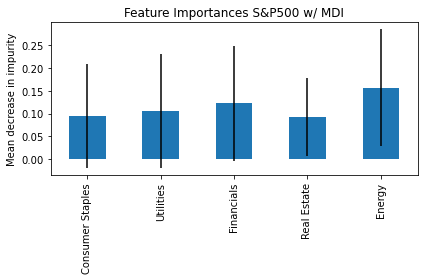

In [14]:
feature_names = X_optimized.columns.to_list()
forest_importances = pd.Series(feat_importances_optimized, index=feature_names)
forest_importances
fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rdm_forest_model.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature Importances S&P500 w/ MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

## Review Optimized Model Values and Accuracy

In [15]:
# store the y_pred array
y_pred_1 = rdm_forest_model.predict(X_test_scaled_1)

# Review the model's predicted test values
print(y_pred_1)

[0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]


## Review Optimized Model Accuracy Score

In [16]:
# Print the balanced_accuracy score of the model
print(balanced_accuracy_score(y_test_1, y_pred_1))

0.5871975806451613


## Review Optimized Model Confusion Matrix

In [17]:
# Generate a confusion matrix for the model
print(confusion_matrix(y_test_1, y_pred_1))

[[19 13]
 [13 18]]


## Review Optimized Model Classification Report Imbalanced

In [18]:
# Print the classification report for the model
print(classification_report_imbalanced(y_test_1, y_pred_1))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.59      0.59      0.58      0.59      0.59      0.35        32
        1.0       0.58      0.58      0.59      0.58      0.59      0.34        31

avg / total       0.59      0.59      0.59      0.59      0.59      0.34        63



## Review Optimized Model Classification Report Imbalanced

In [19]:
# Review the classification report associated with the model predictions.
# Use a classification report to evaluate the model using the predictions and training data
rfm_testing_pred_1 = rdm_forest_model.predict(X_test_scaled_1)
rfm_testing_report_1 = classification_report(y_test_1, rfm_testing_pred_1)

# Print the classification report
print(rfm_testing_report_1)

              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59        32
         1.0       0.58      0.58      0.58        31

    accuracy                           0.59        63
   macro avg       0.59      0.59      0.59        63
weighted avg       0.59      0.59      0.59        63



## Plot ROC Curve

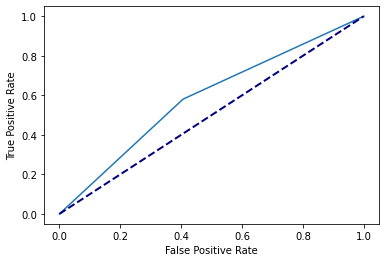

In [20]:
# compute ROC curve
fpr, tpr, thresh = roc_curve(y_test_1, y_pred_1)

# plot ROC results
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")